In [11]:
import os
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import multiprocessing
import itertools as it
from scipy.special import expit
import pymc3 as pm
import arviz as az
import theano.tensor as tt
import warnings
warnings.simplefilter('ignore')

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()  # Nice plot aesthetic

# Make data

In [13]:
np.random.seed(123)

In [14]:
def u(x, alpha):
    return x**(1 - alpha)

In [15]:
task = pd.DataFrame(np.random.random(size=(1000, 4)), columns=["p0", "x0", "p1", "x1"])
task = task[~((task.p0 >= task.p1) & (task.x0 >= task.x1))]
task = task[~((task.p1 >= task.p0) & (task.x1 >= task.x0))]

In [16]:
n = 100
task = task.sample(n=n, replace=False)
task.reset_index(inplace=True, drop=True)
task

,p0,x0,p1,x1
0,0.071194,0.150403,0.698059,0.000120
1,0.659600,0.583528,0.943486,0.526061
2,0.081469,0.423868,0.493148,0.218306
3,0.163338,0.984128,0.227802,0.589415
4,0.924399,0.475190,0.012931,0.965418
...,...,...,...,...
95,0.647290,0.544298,0.014501,0.907783
96,0.732738,0.399097,0.254519,0.890109
97,0.918397,0.091296,0.463653,0.502216
98,0.661386,0.568790,0.104939,0.727241


In [17]:
true_alpha = 0.4

# How does it look like

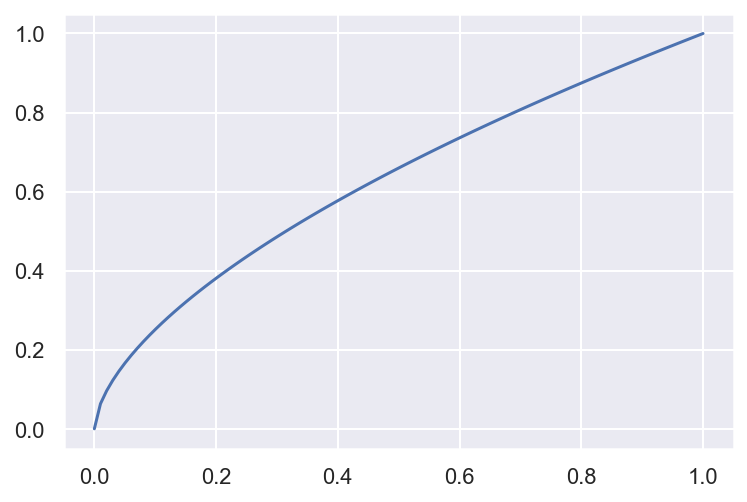

In [18]:
x_plot = np.linspace(0, 1, 100)
plt.plot(x_plot, u(x_plot, true_alpha))

In [19]:
x0 = task.x0.values
x1 = task.x1.values

x = np.hstack((x0, x1))
x_order = np.argsort(x)
x_sorted = x[x_order]

u_sorted = u(x_sorted, true_alpha)

# Simple x => u

In [20]:
with pm.Model() as model:

    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 5)
    η = pm.HalfCauchy('η', 5)
    
    M = pm.gp.mean.Linear(coeffs=0)
    K = η**2 * pm.gp.cov.ExpQuad(1, ρ) 
    
    σ = pm.HalfNormal('σ', 50)
    
    gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    gp.marginal_likelihood('y', X=x_sorted.reshape(-1, 1), y=u_sorted, noise=σ)

In [21]:
with model:
    trace = pm.sample(1000, tune=1000, chains=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, η, ρ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 213 seconds.


In [22]:
x_pred = np.linspace(0, 1, 100)
with model:
    y_pred = gp.conditional("y_pred", x_pred.reshape(-1, 1))
    samples = pm.sample_posterior_predictive(trace, var_names=["y_pred"], samples=10, random_seed=42)

<AxesSubplot:>

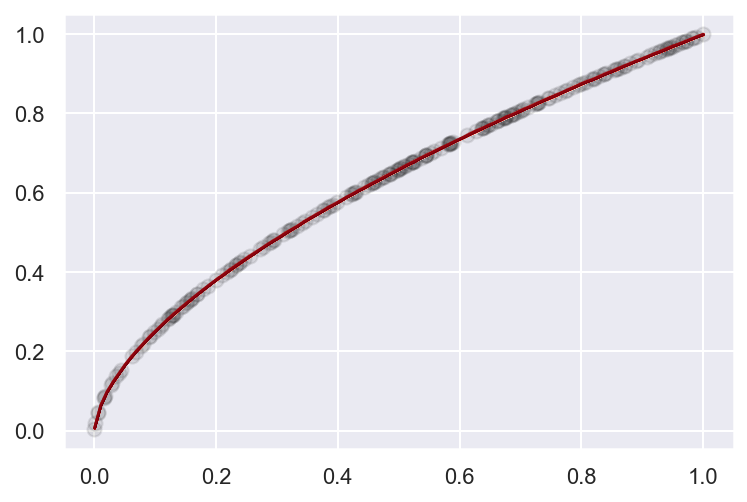

In [23]:
fig, ax = plt.subplots()
ax.scatter(x=x_sorted, y=u_sorted, c='k', s=50, alpha=0.1)
pm.gp.util.plot_gp_dist(ax, samples["y_pred"], x_pred)

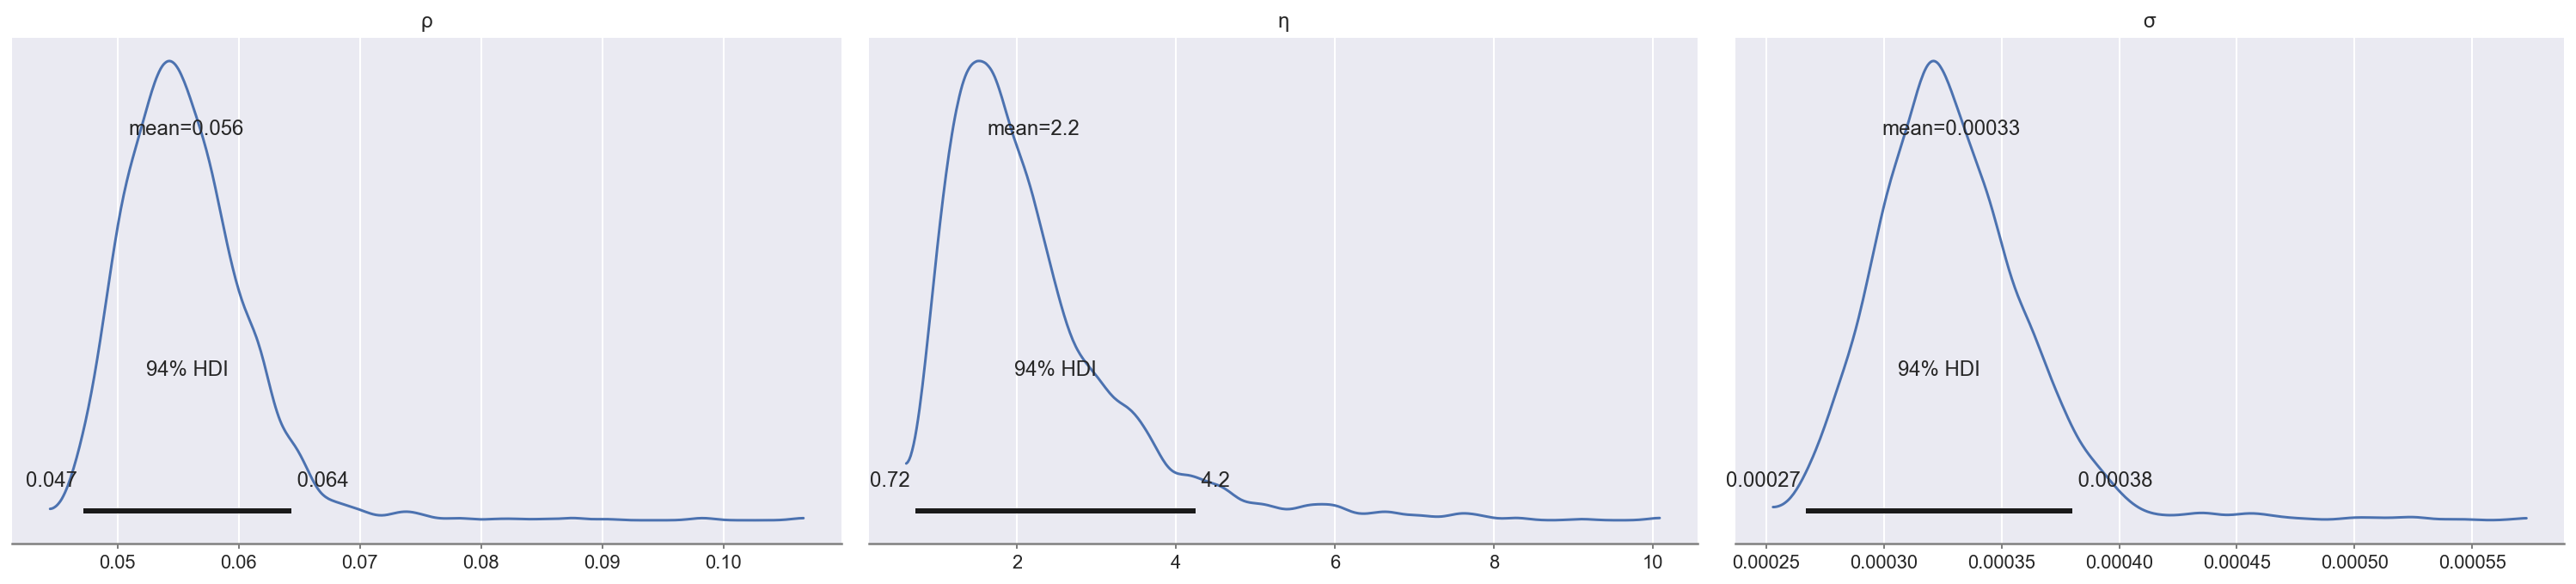

In [24]:
with model:    
    az.plot_posterior(trace, var_names=("ρ", "η", "σ"))

## Using MAP

In [25]:
with pm.Model() as model:

    ρ = pm.HalfCauchy('ρ', 5)
    η = pm.HalfCauchy('η', 5)
    
    M = pm.gp.mean.Linear(coeffs=0)
    K = η**2 * pm.gp.cov.ExpQuad(1, ρ) 
    
    σ = pm.HalfNormal('σ', 50)
    
    gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    gp.marginal_likelihood('y', X=x_sorted.reshape(-1, 1), y=u_sorted, noise=σ)

In [26]:
with model:
    trace = pm.find_MAP()

In [27]:
trace

{'ρ_log__': array(1.50516547),
 'η_log__': array(1.42462932),
 'σ_log__': array(-17.31269625),
 'ρ': array(4.504899),
 'η': array(4.1563169),
 'σ': array(3.02824879e-08)}

In [28]:
X_new = np.linspace(0, 1, 100).reshape(-1, 1)
mu, var = gp.predict(X_new, point=trace, diag=True)

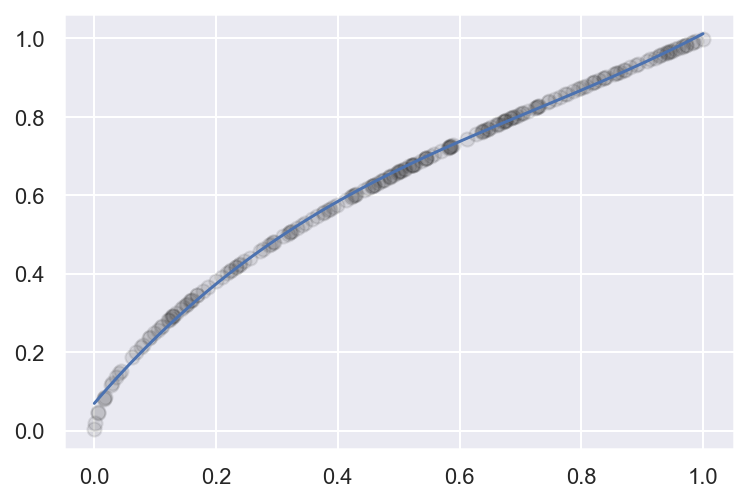

In [29]:
fig, ax = plt.subplots()
ax.plot(X_new.flatten(), mu)
ax.fill_between(x=X_new.flatten(), 
                y1=mu+1.96*np.sqrt(var), 
                y2=mu-1.96*np.sqrt(var), alpha=0.5)
ax.scatter(x=x_sorted, y=u_sorted, c='k', s=50, alpha=0.1)

In [30]:
type(trace)

dict

In [31]:
X_new = np.linspace(0, 1, 100).reshape(-1, 1)

# add the GP conditional to the model, given the new X values
with model:
    try:
        f_pred = gp.conditional("f_pred", X_new)
    except ValueError:
        pass
# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([trace, ], var_names=["f_pred"], samples=100)

<AxesSubplot:>

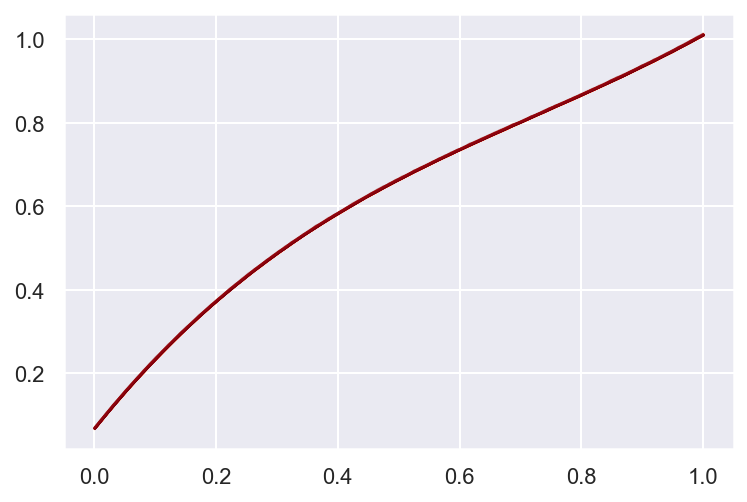

In [32]:
fig, ax = plt.subplots()
pm.gp.util.plot_gp_dist(ax, pred_samples["f_pred"], X_new)

# Using VI

In [33]:
with pm.Model() as model:

    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 5)
    η = pm.HalfCauchy('η', 5)
    
    M = pm.gp.mean.Linear(coeffs=0)
    K = η**2 * pm.gp.cov.ExpQuad(1, ρ) 
    
    σ = pm.HalfNormal('σ', 50)
    
    gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    gp.marginal_likelihood('y', X=x_sorted.reshape(-1, 1), y=u_sorted, noise=σ)

In [34]:
with model:
    mean_field = pm.fit(method="advi", n=20000)

Finished [100%]: Average Loss = -278.64


In [35]:
trace = mean_field.sample(1000)

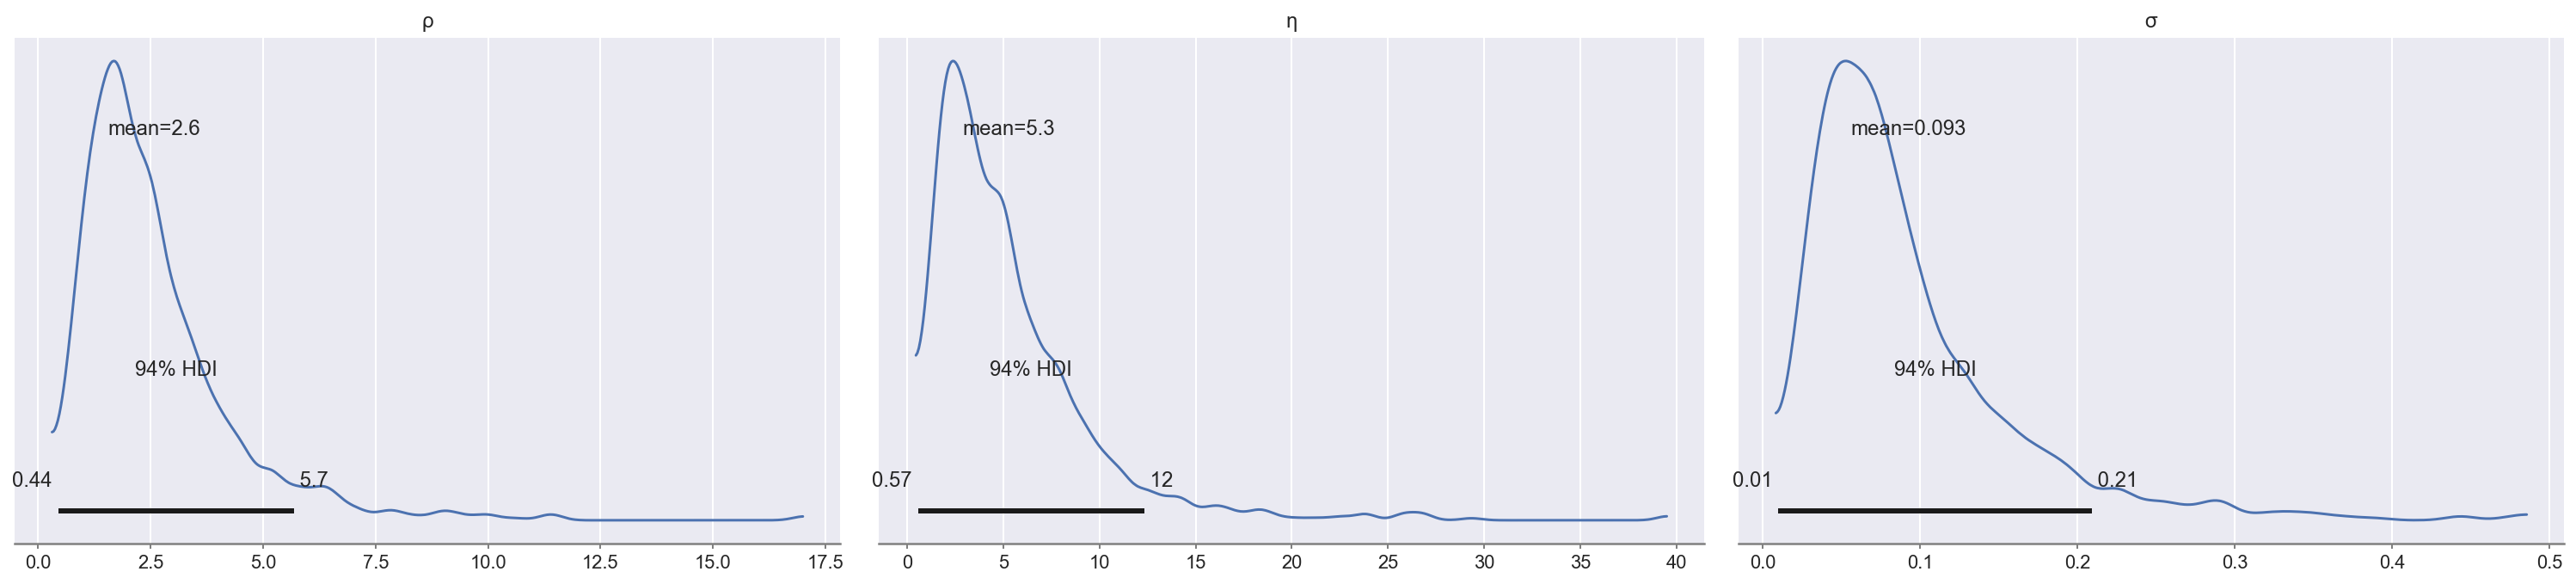

In [36]:
with model:    
    az.plot_posterior(trace, var_names=("ρ", "η", "σ"))

In [37]:
X_new = np.linspace(0, 1, 100).reshape(-1, 1)

with model:
    try:
        f_pred = gp.conditional("f_pred", X_new)
    except ValueError:
        pass

with model:
    pred_samples = pm.sample_posterior_predictive(trace, var_names=["f_pred"])


<AxesSubplot:>

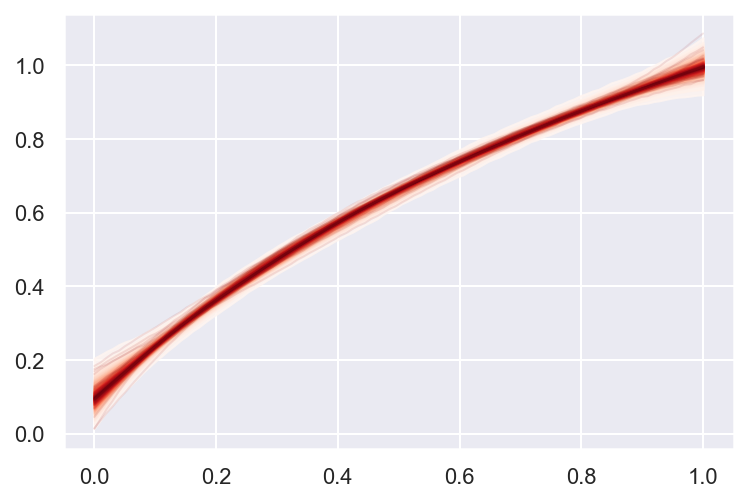

In [38]:
fig, ax = plt.subplots()
pm.gp.util.plot_gp_dist(ax, pred_samples["f_pred"], X_new)